In [1]:
import pandas as pd
import numpy as np

from random import randrange
import pickle 
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

import datetime

import hdbscan
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pprint
import pathlib

import warnings
warnings.filterwarnings('ignore')

#  jupyter notebook stop 8888
#python -m ipykernel install --user --name p3_venv

### Load data

In [3]:
df = pd.read_pickle('data/nem_formatted_data.pkl')
df = df.sort_values(['state', 'datetime'])

# Remove 1st Oct 2020 as the data is not complete
df = df[df.datetime.dt.date.astype('str') != '2020-10-01']

In [4]:
fuel_cols = ['wind', 'solar', 'solar_rooftop', 'blackcoal', 'browncoal','gas','diesel','kerosene','hydro','bagasse','batterys', 'net_import']
index_cols = [ 'state', 'datetime'] 

In [5]:
X = df[fuel_cols]

In [50]:
df.datetime.max()

Timestamp('2020-09-30 00:00:00')

In [6]:
X.shape

(18110, 12)

### Baysian gaussian optimal cluster count

#### Run model

In [ ]:
for alpha in [0.5, 1, 5, 10, 100, 1000]:
    n_components = np.arange(2, 101)
    models =[]
    for n in n_components:
        print('processing n {}'.format(n))
        models.append(BayesianGaussianMixture(n_components = n, 
                                              covariance_type='full', 
                                              random_state=2020,
                                              max_iter = 1000,
                                              weight_concentration_prior_type ='dirichlet_process',
                                              weight_concentration_prior = alpha).fit(X))
# Save the models
pickle.dump(models, open('models/bgmm_1_100_alpha{}.pkl'.format(alpha), 'wb'))

#### Evaluate model

In [7]:
# Create dataframe with columns ['alpha', 'N', 'True_N', 'converged', 'loglik']
result = []
for alpha in [0.5, 1, 5, 10, 100, 1000]:
    models = pickle.load(open('models/bgmm_1_100_alpha{}.pkl'.format(alpha), 'rb'))
    
    for idx, m in enumerate(models):
        labels=m.predict(X)
        components = len(np.unique(labels)) # get number of components
        result.append([alpha, idx + 2, components, m.converged_, m.score(X)])
cols = ['alpha', 'N', 'True_N', 'converged', 'loglik']
result = pd.DataFrame(result, columns = cols)
result['conv'] = 'no'
result.loc[result.converged == True, 'conv'] = 'yes'
result.to_csv('results/bgmm_results.csv', index = False)
result['conv'] = result['conv'].astype('category')

In [8]:
pickle.dump(result, open('results/bgmm_results.pkl', 'wb'))

### Plot predicted cluster components for different alpha settings

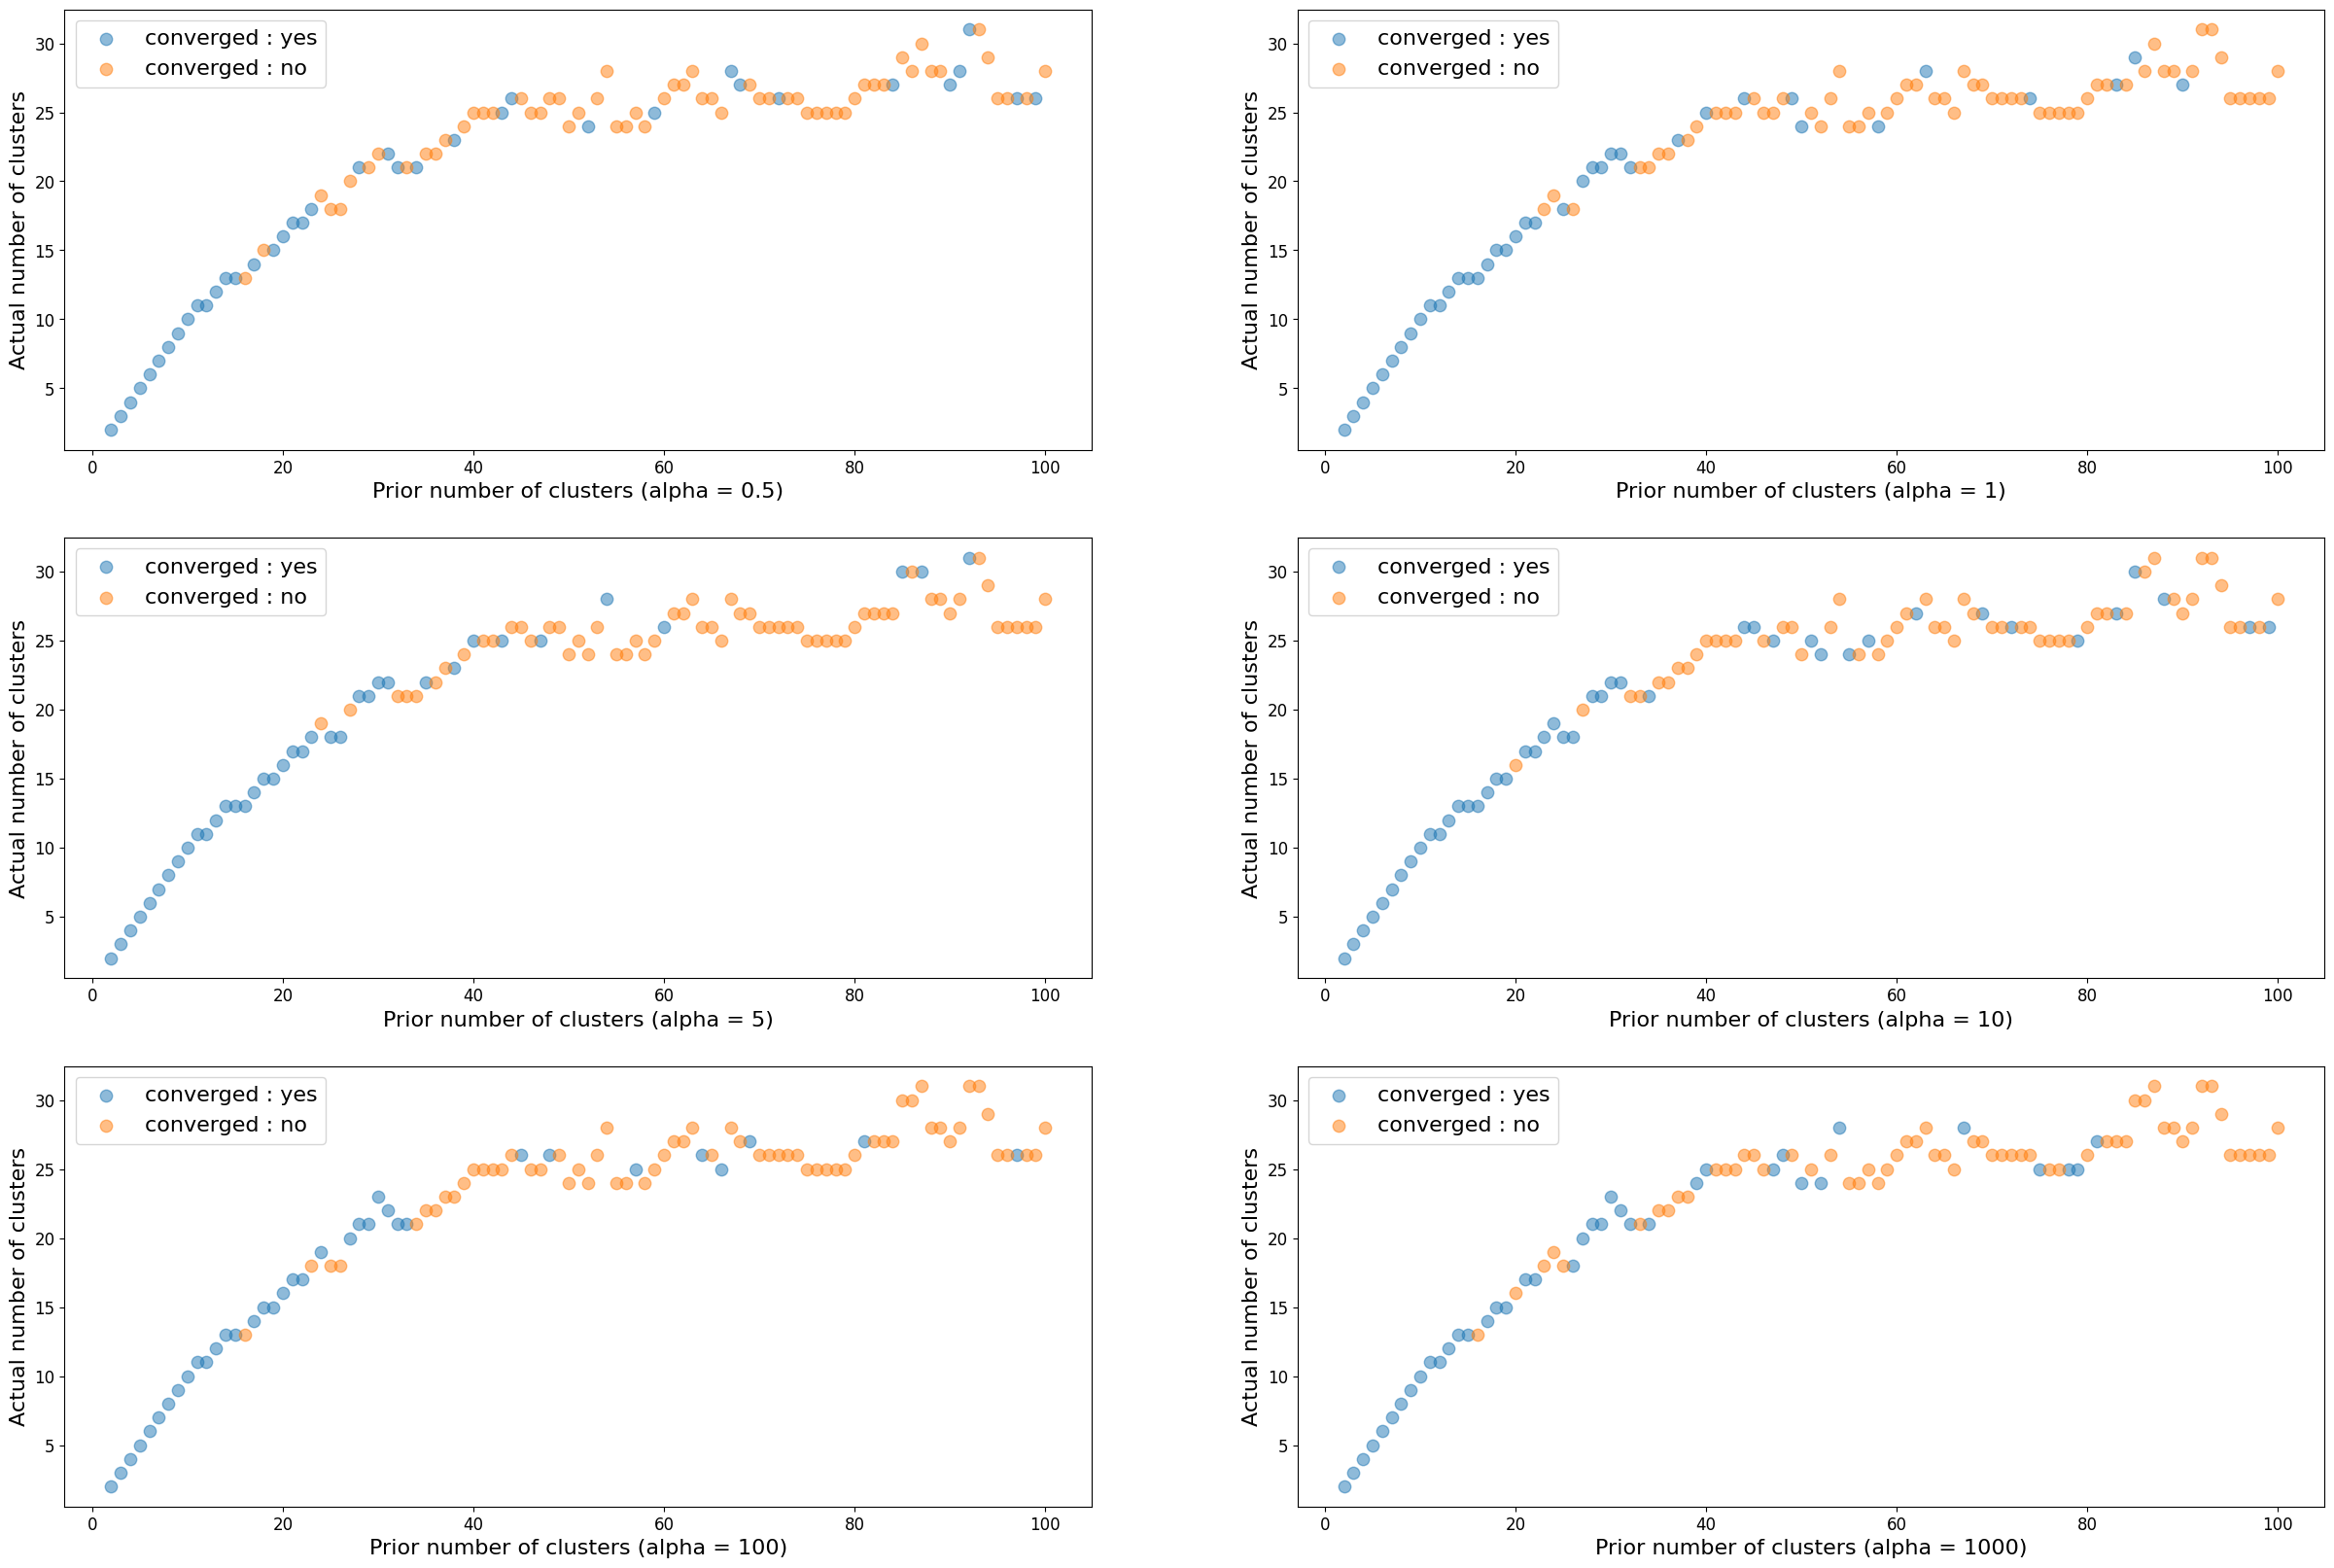

In [9]:
plt.style.use('default')
fig, ax = plt.subplots(3, 2, figsize=(30,20))

def plot_optimal_cluster_all(alpha, idx):
    sub_result = result[result.alpha == alpha]
    s1 = sub_result[sub_result.converged == True]
    s2 = sub_result[sub_result.converged == False]
    ax[idx].scatter(s1['N'], s1['True_N'], label='converged : yes', s=80, alpha = 0.5)
    ax[idx].scatter(s2['N'], s2['True_N'], label='converged : no', s=80, alpha = 0.5)
    ax[idx].legend(loc='best', fontsize = 16)
    ax[idx].set_xlabel('Prior number of clusters (alpha = {})'.format(alpha))
    ax[idx].set_ylabel('Actual number of clusters')
    ax[idx].xaxis.label.set_size(16)
    ax[idx].yaxis.label.set_size(16)
    ax[idx].tick_params(axis='both', which='major', labelsize=12)


plot_optimal_cluster_all(0.5, (0,0))
plot_optimal_cluster_all(1, (0,1))
plot_optimal_cluster_all(5, (1,0))
plot_optimal_cluster_all(10, (1,1))
plot_optimal_cluster_all(100, (2,0))
plot_optimal_cluster_all(1000, (2,1))

### Limit prior clusters to 50

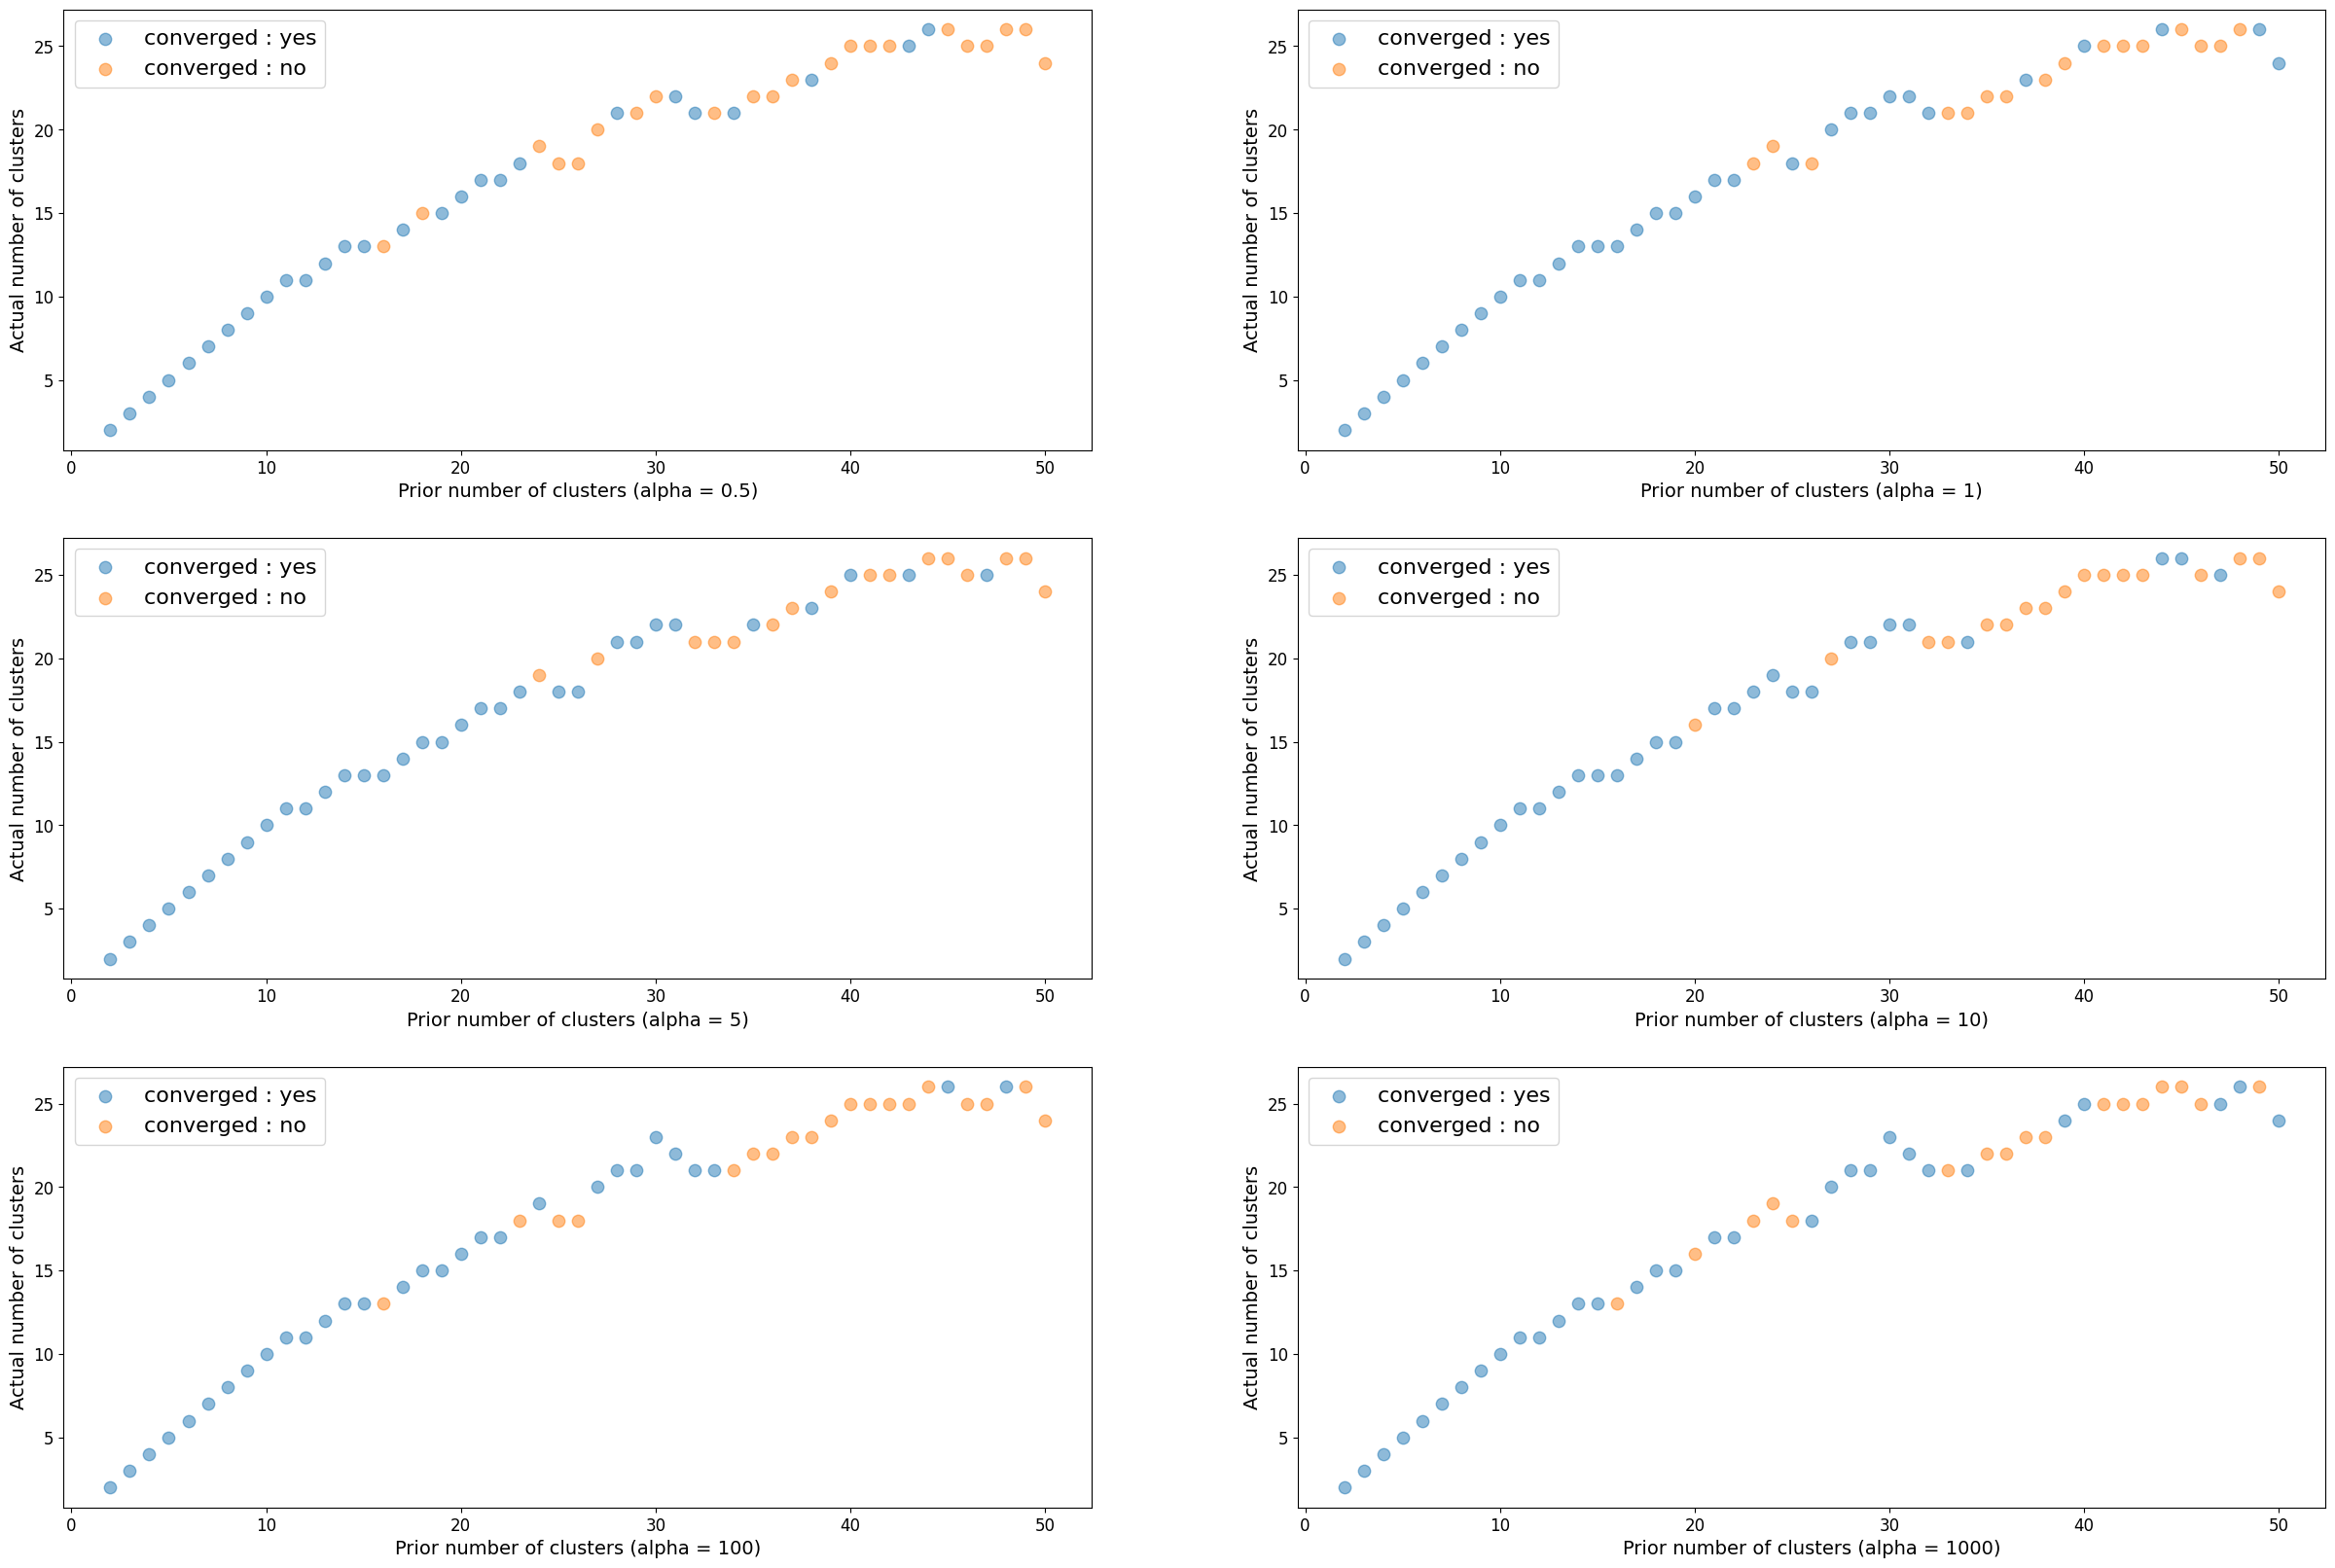

In [10]:
plt.style.use('default')
fig, ax = plt.subplots(3, 2, figsize=(30,20))

cut_off = 50

def plot_optimal_cluster_all(alpha, idx):
    sub_result = result[(result.alpha == alpha) & (result.N <= cut_off)]
    s1 = sub_result[sub_result.converged == True]
    s2 = sub_result[sub_result.converged == False]
    ax[idx].scatter(s1['N'], s1['True_N'], label='converged : yes', s=80, alpha = 0.5)
    ax[idx].scatter(s2['N'], s2['True_N'], label='converged : no', s=80, alpha = 0.5)
    ax[idx].legend(loc='best', fontsize = 16)
    ax[idx].set_xlabel('Prior number of clusters (alpha = {})'.format(alpha))
    ax[idx].set_ylabel('Actual number of clusters')
    ax[idx].xaxis.label.set_size(14)
    ax[idx].yaxis.label.set_size(14)
    ax[idx].tick_params(axis='both', which='major', labelsize=12)


plot_optimal_cluster_all(0.5, (0,0))
plot_optimal_cluster_all(1, (0,1))
plot_optimal_cluster_all(5, (1,0))
plot_optimal_cluster_all(10, (1,1))
plot_optimal_cluster_all(100, (2,0))
plot_optimal_cluster_all(1000, (2,1))

### Plot for alpha = 5, until 50. Also plot loglikihood 

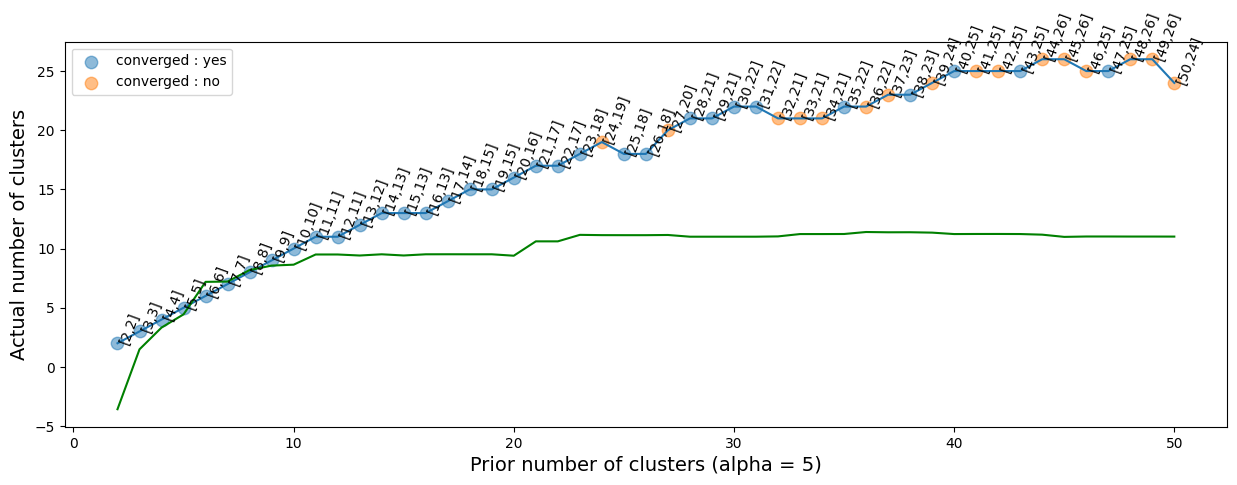

In [11]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(15,5))

cut_off = 50

def plot_optimal_cluster(alpha, annotate):
    sub_result = result[(result.alpha == alpha) & (result.N <= cut_off)]
    x = np.array(sub_result['N'])
    y = np.array(sub_result['True_N'])
    txts = ["[{},{}]".format(a,b) for a,b in zip(x,y)]

    s1 = sub_result[sub_result.converged == True]
    s2 = sub_result[sub_result.converged == False]
    ax.plot(x, y)
    ax.plot(x, sub_result['loglik'], c ='green')
    ax.scatter(s1['N'], s1['True_N'], label='converged : yes', s=80, alpha = 0.5)
    ax.scatter(s2['N'], s2['True_N'], label='converged : no', s=80, alpha = 0.5)
    if annotate:
        for i, txt in enumerate(txts):
            ax.annotate(txt, (x[i], y[i]), rotation = 70)
    ax.legend(loc='best')
    ax.set_xlabel('Prior number of clusters (alpha = {})'.format(alpha))
    ax.set_ylabel('Actual number of clusters')
    ax.xaxis.label.set_size(14)
    ax.yaxis.label.set_size(14)
    ax.tick_params(axis='both', which='major', labelsize=10)


    
plot_optimal_cluster(5, True)

In [ ]:
ncomponents_w1 = {}
ncomponents_w2 = {}
ncomponents_w3 = {}
#for alpha in [0.5, 1, 5, 100, 1000]:
models = pickle.load(open('models/bgmm_1_100_alpha{}.pkl'.format(5), 'rb'))
for idx, m in enumerate(models):
    w = np.array(m.weights_) * 100
    w1 = (w >= 10).sum()
    w2 = (w >= 1).sum()
    w3 = (w > 0).sum()
    ncomponents_w1[idx] = w1
    ncomponents_w2[idx] = w2
    ncomponents_w3[idx] = w3

In [ ]:
models[2].weights_ * 100

In [ ]:
plt.style.use('default')
conv = [m.converged_ for m in models]
end = 40
# plt.plot(list(range(2, end + 2)), bgmm_perf_loglik[0:end], label='loglik')
plt.scatter(list(range(2, end + 2)), list(ncomponents_w1.values())[0:(end)], label='>10')
plt.scatter(list(range(2, end + 2)), list(ncomponents_w2.values())[0:(end)], label='>1')
plt.legend(loc='best')
plt.xlabel('n_components')